In [76]:
import ephem
import datetime
import numpy as np
import time as t
import serial
import matplotlib.pyplot as plt

# Sun Tracking

In [41]:
def get_sun_position(date_time, latitude, longitude):
    observer = ephem.Observer()

    # Set the observer's location (you can change this to your desired location)
    # observer.lat = '44.233334'  # Replace with your latitude
    # observer.long = '-76.500000'  # Replace with your longitude
    observer.lat = latitude  # Replace with your latitude
    observer.long = longitude  # Replace with your longitude    
    observer.date = date_time

    sun = ephem.Sun()
    sun.compute(observer)

    azimuth = sun.az * 180 / ephem.pi  # Convert radians to degrees
    altitude = sun.alt * 180 / ephem.pi  # Convert radians to degrees

    return azimuth, altitude

# We should set maximums on the altitude & azimuth so it don't break
# Positive directions are CCW and Down
# Offset of 24.62 degrees
class Satellite:
    
    def __init__(self, astro_azimuth = 0, astro_altitude = 0, motor_azimuth = 45, motor_altitude = 45):
        self.default_azimuth  = motor_azimuth
        self.default_altitude = motor_altitude
        self.current_azimuth = self.default_azimuth
        self.current_altitude = self.default_altitude 

        self.default_astro_azimuth = astro_azimuth
        self.default_astro_altitude = astro_altitude + 24.62
        self.current_astro_azimuth = self.default_astro_azimuth
        self.current_astro_altitude = self.default_astro_altitude

    # m1 - Azimuth 80 steps / deg, m2 - Altitude 40 steps / deg
    def move_steps(self, m1_step, m2_step):
        
        M1 = str(-1*m1_step).encode('utf-8')
        M2 = str(-1*m2_step).encode('utf-8')
        
        ser = serial.Serial(port='COM4', baudrate=9600)
        
        if(m2_step==0 and m1_step==0):
            return
        elif(m2_step==0):    
            ser.write(b'F,C,I1M' + M1 + b', R')
            self.current_azimuth += m1_step/80
            self.current_altitude += m2_step/40
        elif(m1_step==0):    
            ser.write(b'F,C,I2M' + M2 + b', R')
            self.current_azimuth += m1_step/80
            self.current_altitude += m2_step/40
        else:
            ser.write(b'F,C,I1M' + M1 + b', I2M' + M2 + b', R')
            self.current_azimuth += m1_step/80
            self.current_altitude += m2_step/40
        return

    def move(self, m1_degrees=0, m2_degrees=0, sleep=1):
        self.move_steps(m1_degrees*80 ,m2_degrees*40)
        self.current_astro_azimuth += m1_degrees
        self.current_astro_altitude += m2_degrees
        t.sleep(sleep)

    # m1 - Azimuth 80 steps / deg - 0.0125 min step, m2 - Altitude 40 steps / deg - 0.025 min step
    def move_to(self, m1_angle, m2_angle, sleep = 1):
        deltam1 = m1_angle - self.current_astro_azimuth
        if(deltam1 < 0.0125 and deltam1 > -0.0125):
            deltam1 = 0
        deltam2 = m2_angle - self.current_astro_altitude
        if(deltam2 < 0.025 and deltam2 > -0.025):
            deltam2 = 0   
        self.move(deltam1,deltam2,sleep)

    def set_to_default(self):
        self.move_to(self.default_astro_azimuth, self.default_astro_altitude)

    def set_to_motor_default(self):
        self.move(self.default_azimuth-self.current_azimuth, self.default_altitude-self.current_altitude)

    def get_position(self): # Outputs astronomical azimuth and altitude
        return self.current_astro_azimuth, self.current_astro_altitude

    def track_sun(self,verbose = False):
        if verbose:
            print("Welcome to the autonomous celestial body tracking system! Before we get started, we need a few inputs...\n")
            print("Set the coordinates of the device.")
            latitude = str(input("Latitude:") or '44.233334')
            longitude = str(input("Longitude:") or '-76.500000')
            
            print("\nEnter the start time of the run.")
            year_Start = int(input("Year:") or 2024) 
            month_Start = int(input("Month:") or 4)
            day_Start = int(input("Day:") or 8)
            hour_Start = int(input("Hour (24hr):") or 14)
            minute_Start = int(input("Minute:") or 9)
            second_Start = int(input("Second:") or 0)
            
            print("\nEnter the end time of the run.")
            year_End = int(input("Year:") or 2024) 
            month_End = int(input("Month:") or 4)
            day_End = int(input("Day:") or 8)
            hour_End = int(input("Hour (24hr):") or 16)
            minute_End = int(input("Minute:") or 34)
            second_End = int(input("Second:") or 0)
            
            startTime = datetime.datetime(year_Start, month_Start, day_Start, hour_Start, minute_Start, second_Start)    
            endTime = datetime.datetime(year_End, month_End, day_End, hour_End, minute_End, second_End)  
            
            N = int(input("# of steps:") or 200)

        else:
            latitude = '44.233334'
            longitude = '-76.500000'
            #startTime = datetime.datetime(2024, 4, 8, 14, 9, 0)    
            #endTime = datetime.datetime(2024, 4, 8, 16, 34, 0)

            startTime = datetime.datetime.now() + datetime.timedelta(hours = 5)
            endTime = startTime + datetime.timedelta(minutes = 1) 
            N = 270
            
        deltaT = (endTime - startTime)/N
        time = startTime

        for i in range(N):
            azimuth_val, altitude_val = get_sun_position(time, latitude, longitude)
            time = time + deltaT
            self.move_to(round(azimuth_val,3), round(altitude_val,4), sleep = deltaT.total_seconds())   
            print(round(azimuth_val,4),round(altitude_val,3),deltaT.total_seconds())

    def raster_scan(self, az_span, al_span, az_num_steps, al_num_steps):
        # Set distance for a single step
        az_step = az_span/az_num_steps
        al_step = al_span/al_num_steps
        print(self.current_azimuth, self.current_altitude)  
        self.move(-1*az_span/2, al_span/2)
        print(self.current_azimuth, self.current_altitude)  
        for j in range(al_num_steps+1):
            for i in range(az_num_steps+1):
                self.move(az_step, 0)
                print(self.current_azimuth, self.current_altitude)   
            self.move(-1*az_span, -1*al_step)
            print(self.current_azimuth, self.current_altitude)


In [86]:
get_sun_position(datetime.datetime.now() + datetime.timedelta(hours = 5), 44.23333, -76.500000)

(231.11617087046963, 32.55694020722827)

In [54]:
s = Satellite(180)

s.raster_scan(30, 30, 3, 2)

45 45
30.0 60.0
40.0 60.0
50.0 60.0
60.0 60.0
70.0 60.0
40.0 45.0
50.0 45.0
60.0 45.0
70.0 45.0
80.0 45.0
50.0 30.0
60.0 30.0
70.0 30.0
80.0 30.0
90.0 30.0
60.0 15.0


In [179]:
s.set_to_motor_default()

In [63]:
print(s.current_azimuth, s.current_altitude)

45.0 45.0


In [51]:
# s.track_sun()
# s.set_to_default()

In [23]:
latitude = '44.13'
longitude = '-76.29'
time = datetime.datetime.now() + datetime.timedelta(minutes = 5)
azimuth_val, altitude_val = get_sun_position(time, latitude, longitude)
print(azimuth_val, altitude_val)

145.06977555572914 19.58381891658404


# Py SDR

In [173]:
# An attempt to set up SDR software
from rtlsdr import RtlSdr
from pylab import *
from rtlsdr import *
from IPython.display import clear_output

# rtl_test -t   # Run this in command prompt to find 
                # available sdr devices with device index and serial number
sdr = RtlSdr()

# configure device
# LNB O/P: 950-1450 MHz
sdr.sample_rate = 3.2e6
sdr.center_freq = 1.05e9
sdr.gain = 'auto'

# samples = sdr.read_samples(256 * 1024)
# print(samples.shape)
# frequencies, psd_values = psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
# print(samples[0])

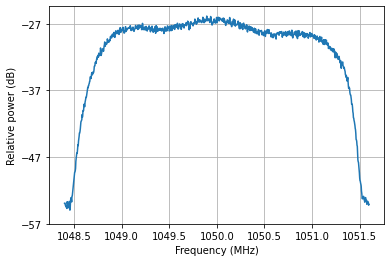

KeyboardInterrupt: 

In [176]:
fig, ax = plt.subplots()
step = 0.001e9
for i in range(100):
    # sdr.center_freq = 1.4e9 + step*i
    samples = sdr.read_samples(256 * 1024)
    print(np.max(samples))
    # Clear the previous plot
    ax.clear()

    # Calculate PSD
    psd_values, frequencies = psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
    xlabel('Frequency (MHz)')
    ylabel('Relative power (dB)')

    # Display the plot and clear the previous output
    display(fig)
    clear_output(wait=True)

    time.sleep(1e-3)

    plt.figure()
    plt.plot(frequencies[192:832], psd_values[192:832])
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('PSD (1/Hz)')
    plt.grid(True)
    plt.show()

    # pause = input("")

# print(frequencies[192], psd_values[192])
# print(frequencies[832], psd_values[832])
print(np.max(psd_values))
plt.figure()
plt.plot(frequencies, psd_values)
    
# plt.close(fig)  # Close the figure after the loop

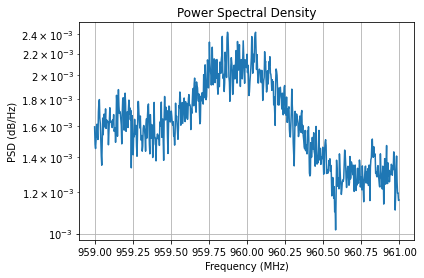

959.0 0.0015964343512887725
961.0 0.001166364313294836


In [90]:
plt.plot(frequencies[192:832], psd_values[192:832])
plt.yscale('log')  # Set x-axis to logarithmic scale
plt.title('Power Spectral Density')
plt.xlabel('Frequency (MHz)')
plt.ylabel('PSD (dB/Hz)')
plt.grid(True)
plt.show()

print(frequencies[192], psd_values[192])
print(frequencies[832], psd_values[832])

In [213]:
s.set_to_motor_default()

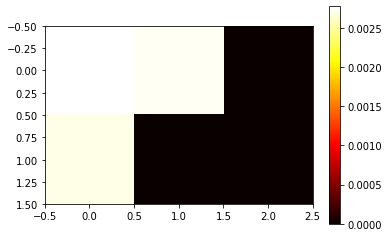

0.0027456845426396316


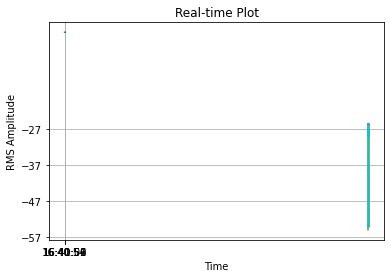

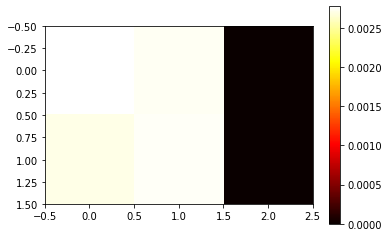

52.5 40.0
0.002733131770520032


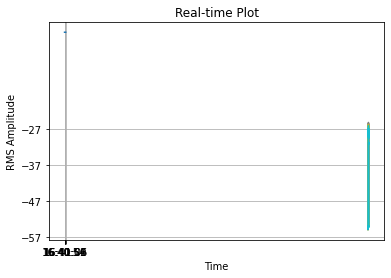

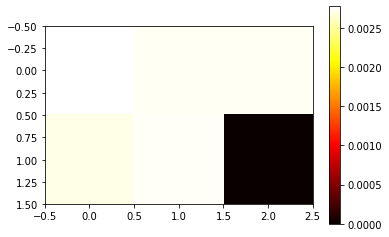

0.002733155070001026


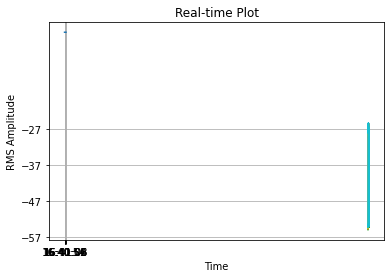

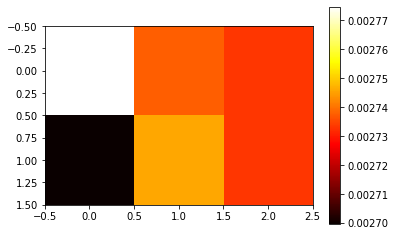

57.5 35.0
16:40:54 0.00277469690198183
16:40:56 0.002699596481046884
16:40:59 0.002737694939607606
16:41:02 0.0027456845426396316
16:41:05 0.002733131770520032
16:41:08 0.002733155070001026


In [214]:
timestamps = []
RMS_vals = []
batches = 10

# self.move(-1*az_span/2, al_span/2)
#         print(self.current_azimuth, self.current_altitude)  
#         for j in range(al_num_steps+1):
#             for i in range(az_num_steps+1):
#                 self.move(az_step, 0)
#                 print(self.current_azimuth, self.current_altitude)   
#             self.move(-1*az_span, -1*al_step)
#             print(self.current_azimuth, self.current_altitude)

al_num_steps = 2
az_num_steps = 1
az_span = 5
al_span = 10
az_step = az_span/az_num_steps
al_step = al_span/al_num_steps

RMS_positions = np.zeros([az_num_steps, al_num_steps])

# for epoch in range(epochs):
s.move(-1*az_span/2, al_span/2)
print(s.current_azimuth, s.current_altitude)
for j in range(al_num_steps):
    for i in range(az_num_steps): 
        # print(s.current_azimuth, s.current_altitude)
        RMS_batch = []
        for batch in range(batches):
            test_time = datetime.datetime.now()
            samples = sdr.read_samples(256*1024)
            psd_values, frequencies = psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
            
            # RMS_batch.append(np.sqrt(np.mean(np.square(real(samples[192:832])))))
            RMS_batch.append(np.max(psd_values))
            
        RMS_vals.append(np.sum(RMS_batch)/batches)
        print(np.sum(RMS_batch)/batches)
        
        RMS_positions[i, j] = np.sum(RMS_batch)/batches
        
        current_time = datetime.datetime.now()
        timestamps.append(current_time.strftime("%H:%M:%S"))
        
        time.sleep(1e-3)
    
        plt.plot(timestamps, RMS_vals)
        plt.title('Real-time Plot')
        plt.xlabel('Time')
        plt.ylabel('RMS Amplitude')
    
        # Display the plot and clear the previous output
        plt.show()
        if (j < al_num_steps):
            if(i < az_num_steps):
                clear_output(wait=True)
    
        plt.imshow(RMS_positions, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()
        
        s.move(az_step, 0)

    s.move(-1*az_span, -1*al_step)
    print(s.current_azimuth, s.current_altitude)
    
for timestamp, RMS_val in zip(timestamps, RMS_vals):
    print(timestamp, RMS_val)

# use matplotlib to estimate and plot the PSD
# psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
# xlabel('Frequency (MHz)')
# ylabel('Relative power (dB)')
# show()

[[0.00963755 0.00956655 0.00972135 0.00953479]
 [0.00952338 0.00966547 0.00955187 0.00966274]
 [0.0092494  0.00966457 0.00952652 0.00972483]
 [0.00970081 0.00964716 0.00975902 0.00965445]]


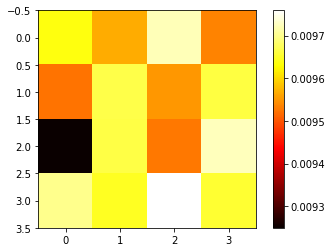

In [75]:
print(RMS_positions)
plt.imshow(RMS_positions, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
timestamps = []
RMS_vals = []
epochs = 30
batches = 20


for epoch in range(epochs):
    RMS_batch = []
    for batch in range(batches):
        test_time = datetime.datetime.now()
        samples = sdr.read_samples(256*1024)
        
        RMS_batch.append(np.sqrt(np.mean(np.square(real(samples[192:832])))))
        
    RMS_vals.append(np.sum(RMS_batch)/batches)
    
    current_time = datetime.datetime.now()
    timestamps.append(current_time.strftime("%H:%M:%S"))
    
    time.sleep(1e-3)

    plt.plot(timestamps, RMS_vals)
    plt.title('Real-time Plot')
    plt.xlabel('Time')
    plt.ylabel('RMS Amplitude')

    # Display the plot and clear the previous output
    plt.show()
    if (epoch < epochs-1):
        clear_output(wait=True)

for timestamp, RMS_val in zip(timestamps, RMS_vals):
    print(timestamp, RMS_val)

# use matplotlib to estimate and plot the PSD
# psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
# xlabel('Frequency (MHz)')
# ylabel('Relative power (dB)')
# show()

In [21]:
while True:
    test_time = datetime.datetime.now()
    print(test_time.strftime("%H:%M:%S"))
    samples = sdr.read_samples(256*1024)

13:36:22
13:36:22
13:36:22
13:36:22
13:36:23
13:36:23
13:36:23
13:36:23
13:36:23
13:36:23
13:36:23
13:36:23
13:36:23
13:36:24
13:36:24
13:36:24
13:36:24
13:36:24
13:36:24
13:36:24
13:36:24
13:36:24
13:36:25
13:36:25
13:36:25
13:36:25
13:36:25
13:36:25
13:36:25
13:36:25
13:36:25
13:36:25
13:36:26
13:36:26
13:36:26
13:36:26
13:36:26
13:36:26
13:36:26
13:36:26
13:36:26
13:36:27
13:36:27
13:36:27
13:36:27
13:36:27
13:36:27
13:36:27


KeyboardInterrupt: 

# Image Generation

In [16]:
import ephem
import math
from operator import itemgetter

def check_n
on_zero(x):
    return x > 0

# Date
timetuple = (2015, 3, 20, 8, 10, 00)

# Location
gatech = ephem.Observer()
gatech.lon, gatech.lat = '-1.268304', '51.753101' #SBS Oxford
gatech.date=timetuple

# Objects
sun, moon = ephem.Sun(), ephem.Moon()

# Output list
results=[]

for x in range(0,11000):
    gatech.date= (ephem.date(ephem.date(timetuple)+x*ephem.second))
    sun.compute(gatech)
    moon.compute(gatech)
    r_sun=sun.size/2
    r_moon=moon.size/2
    s=math.degrees(ephem.separation((sun.az, sun.alt), (moon.az, moon.alt)))*60*60

    ## Calculate the size of the lune (http://mathworld.wolfram.com/Lune.html) in arcsec^2
    if s<(r_moon+r_sun):
        lunedelta=0.25*math.sqrt((r_sun+r_moon+s)*(r_moon+s-r_sun)*(s+r_sun-r_moon)*(r_sun+r_moon-s))
    else: ### If s>r_moon+r_sun there is no eclipse taking place
        lunedelta=None
        percent_eclipse=0
    if lunedelta: 
        lune_area=2*lunedelta + r_sun*r_sun*(math.acos(((r_moon*r_moon)-(r_sun*r_sun)-(s*s))/(2*r_sun*s))) - r_moon*r_moon*(math.acos(((r_moon*r_moon)+(s*s)-(r_sun*r_sun))/(2*r_moon*s)))
        percent_eclipse=(1-(lune_area/(math.pi*r_sun*r_sun)))*100 # Calculate percentage of sun's disc eclipsed using lune area and sun size
    results.append([gatech.date.datetime(),s,sun.size,moon.size,lune_area if lunedelta else 0, percent_eclipse]) ### Append to list of lists
gen=(x for x in results) ### Find Max percentage of eclipse...
max_eclipse=max(gen, key=itemgetter(5))
print("Max eclipse at: " + str(max_eclipse[0])) ### ...and return the time
print("Max percent: " + '%.2f' % max_eclipse[5]) ### ...and return the percentage
gen=(x for x in results)
print("First contact: " + str(next(x for x in gen if check_non_zero(x[5]))[0])) # Find first contact...
print("Last contact: " + str(next(x for x in gen if x[5]==0)[0])) ### ...and last contact

Max eclipse at: 2015-03-20 09:30:11
Max percent: 85.86
First contact: 2015-03-20 08:24:21.000001
Last contact: 2015-03-20 10:40:05


In [20]:
print(sun.size/3600)
print(moon.size/3600)

0.535383775499132
0.5630426364474826


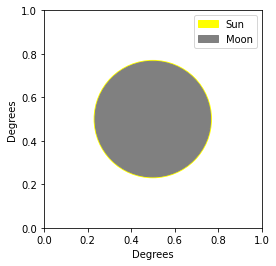

161.41710933410263 36.59099336501038
160.4674808130391 36.82985874066406


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import ephem

def get_object_size_degrees(obj):
    # Convert arcseconds to degrees
    return ephem.degrees(obj.size / 3600)

def plot_celestial_objects(observer):
    sun = ephem.Sun()
    moon = ephem.Moon()

    sun.compute(observer)
    moon.compute(observer)

    # Get object sizes in degrees
    sun_size_degrees = get_object_size_degrees(sun)
    moon_size_degrees = get_object_size_degrees(moon)

    # Plotting
    fig, ax = plt.subplots()

    # Plot the Sun as a yellow circle
    sun_circle = plt.Circle((0.5, 0.5), sun_size_degrees / 2, color='yellow', label='Sun')
    ax.add_patch(sun_circle)

    # Plot the Moon as a gray circle
    moon_circle = plt.Circle((0.5, 0.5), moon_size_degrees / 2, color='gray', label='Moon')
    ax.add_patch(moon_circle)

    # Set aspect ratio to be equal
    ax.set_aspect('equal', adjustable='box')

    # Set axis limits based on object sizes
    # ax.set_xlim(155, 162)
    # ax.set_ylim(32, 40)
    
    # Set axis labels
    ax.set_xlabel('Degrees')
    ax.set_ylabel('Degrees')

    # Set legend
    ax.legend()

    # Show the plot
    plt.show()

# Set up observer
observer = ephem.Observer()
observer.lat = '44.233334'  # Latitude of the observer (e.g., 0 degrees at the equator)
observer.lon = '-76.500000'  # Longitude of the observer (e.g., 0 degrees at the prime meridian)
observer.date = datetime.datetime.now()  # Date for the observation

# Plot celestial objects
plot_celestial_objects(observer)

print(sun.az * 180 / ephem.pi, sun.alt * 180 / ephem.pi)
print(moon.az * 180 / ephem.pi, moon.alt * 180 / ephem.pi)
